#### **Import Libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks")

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5, 2)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.unicode_minus'] = False

#### **Load Dataset**
- 1번함체: CG_1(이격), CG_2(침하) // TT_1 (상부경사), TT_2 (하부경사)
- 2번함체: CG_3(이격), CG_4(침하) // TT_3 (상부경사), TT_4 (하부경사)
- 온도: TC_1_Avg(concrete temp), TC_2_Avg(air temp)
- Label: 0(baseline), 1(outliers) // 2023.01.01: Initial point for abnomaly

In [2]:
# Define filename
# fn_name = 'J_Dataset_1101_0630.csv'
fn_name = 'J_Dataset_1101_0630_outlier_1sig.csv'
# fn_name = 'J_Dataset_1101_0630_outlier_2sig.csv'
# fn_name = 'J_Dataset_1101_0630_outlier_3sig.csv'

# Read csv file
df = pd.read_csv(fn_name)

# Convert string in time column to datatime (Change data type)
df.Time = pd.to_datetime(df.Time)

# Define columnnames for seperating CAISSON1 & CAISSON2
df1_col = ['Time', 'CG_1', 'CG_2', 'TT_1', 'TT_2', 'TC_1_Avg', 'TC_2_Avg', 'Waterlevel']
df3_col = ['Time', 'CG_3', 'CG_4', 'TT_3', 'TT_4', 'TC_1_Avg', 'TC_2_Avg', 'Waterlevel']

# Rename the column names, since original files have different name of labels.
if 'Label_1' in df.columns:
    df1_col.append('Label_1')
    df1 = df[df1_col]
    df1.columns = ['Label'  if col_[:5] == 'Label' else col_ for col_ in df1.columns]

    df3_col.append('Label_2')
    df3 = df[df3_col]
    df3.columns = ['Label'  if col_[:5] == 'Label' else col_ for col_ in df3.columns]
else:
    df1_col.append('Label')
    df1 = df[df1_col]
    df3_col.append('Label')
    df3 = df[df3_col]

print('=========' * 5)
print(f'Caisson #1: shape = {df1.shape}')
display(df1)
print('=========' * 5)
print(f'Caisson #3: shape = {df3.shape}')
display(df3)

Caisson #1: shape = (34037, 9)


,Time,CG_1,CG_2,TT_1,TT_2,TC_1_Avg,TC_2_Avg,Waterlevel,Label
0,2022-11-01 00:00:00,0.00000,0.000000,0.000000,0.000000,13.06,14.44,563.0,0
1,2022-11-01 00:10:00,0.00200,-0.003000,0.000000,0.000000,13.07,14.56,543.0,0
2,2022-11-01 00:20:00,0.00500,-0.005000,-0.001000,0.000000,13.10,14.38,523.0,0
3,2022-11-01 00:30:00,0.00800,-0.007000,-0.001000,0.000000,13.13,14.34,504.0,0
4,2022-11-01 00:40:00,0.01100,-0.009000,-0.001000,0.000000,13.16,14.45,484.0,0
...,...,...,...,...,...,...,...,...,...
34032,2023-06-30 23:10:00,-6.30179,1.090002,0.078931,0.363182,25.93,23.42,458.0,2
34033,2023-06-30 23:20:00,-6.29379,1.089002,0.077931,0.363182,25.82,23.29,480.0,2
34034,2023-06-30 23:29:00,-6.28579,1.088002,0.077931,0.363182,25.72,23.24,503.0,2
34035,2023-06-30 23:40:00,-6.27779,1.087002,0.077931,0.362182,25.65,23.15,527.0,2


Caisson #3: shape = (34037, 9)


,Time,CG_3,CG_4,TT_3,TT_4,TC_1_Avg,TC_2_Avg,Waterlevel,Label
0,2022-11-01 00:00:00,0.000000,0.000000,0.000000,0.000000,13.06,14.44,563.0,0
1,2022-11-01 00:10:00,0.002000,0.000000,0.000000,0.000000,13.07,14.56,543.0,0
2,2022-11-01 00:20:00,0.004000,0.001000,-0.001000,0.000000,13.10,14.38,523.0,0
3,2022-11-01 00:30:00,0.005000,0.001000,-0.001000,-0.001000,13.13,14.34,504.0,0
4,2022-11-01 00:40:00,0.007000,0.001000,-0.001000,-0.001000,13.16,14.45,484.0,0
...,...,...,...,...,...,...,...,...,...
34032,2023-06-30 23:10:00,-4.696372,0.095703,0.036285,0.135566,25.93,23.42,458.0,1
34033,2023-06-30 23:20:00,-4.687372,0.094703,0.036285,0.135566,25.82,23.29,480.0,1
34034,2023-06-30 23:29:00,-4.678372,0.093703,0.035285,0.135566,25.72,23.24,503.0,1
34035,2023-06-30 23:40:00,-4.669372,0.092703,0.035285,0.135566,25.65,23.15,527.0,1


#### **Define helper functions**

In [27]:
# Extract indices for normal, abnormals for plot and train_test_split
def find_indices_labels(df):
    index_ = []
    for ind in df.Label.unique():
        index_.append(df.Label == ind)
    return index_
    
# Plot label information over time
def plot_data_labels(df, color_type_str = ['blue', 'orange', 'red']):
    # Extract indices for normal & abnormals
    df_ind = find_indices_labels(df)

    # Plot scatter plot (Time index vs. Label)
    plt.figure(figsize = (10, 3))
    for label_ind in range(len(df_ind)):
        indice_ = df_ind[label_ind]
        plt.plot(df.Time[indice_], df.Label[indice_], marker = '.', color = color_type_str[label_ind])
    plt.xlabel('Time')
    plt.ylabel('Label')
    plt.gca().set_yticks([0, label_ind])
    plt.grid(linestyle = ':')
    if 'CG_1' in df.columns:
        plt.title('Caisson #1')
    else:
        plt.title('Caisson #3')
    plt.show()

# Plot measurements over time
def show_lineplots_data(df, cols_interest = None,  color_type_str = ['blue', 'orange', 'red']):
    # If there is no column of interest, define default list of columns
    if cols_interest is None:
        cols_interest = [f'CG_{i}' for i in range(1, 5)] + [f'TT_{i}' for i in range(1, 5)]


    # Extract indices for normal & abnormals
    df_ind = find_indices_labels(df)

    for col0_ in df.columns:
        if col0_ in cols_interest:
            plt.figure(figsize = (10, 3))
            for label_ind in range(len(df_ind)):
                indice_ = df_ind[label_ind]
                plt.plot(df.Time[indice_], df.loc[:, col0_][indice_], marker = '.', color = color_type_str[label_ind])

            plt.xlabel('Time')
            plt.ylabel(col0_)

            plt.grid(linestyle = ':')
            if 'CG_1' in df.columns:
                plt.title('Caisson #1')
            else:
                plt.title('Caisson #3')
            plt.show()


# Show pairplots in bivariate plot
def show_scatter_plots_data(df, col_interest, df_interest = None):
    if df_interest is None:
        X = df[col_interest]
    else:
        index_interest = []
        for i, index_ in enumerate(df_interest):
            if i == 0:
                index_interest = index_
            else:
                index_interest += index_
        X = df[col_interest].loc[index_interest]

    display(X)
    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list('blue-yellow', ['blue', 'red'])

    if len(df_interest) > 2:
        markers=["o", "s", 'd']
    else:
        markers=["o","s"]


    g = sns.pairplot(X, hue="Label", kind='reg', plot_kws={'scatter_kws': {'s':12, 'alpha': 0.3, 'edgecolor':"none"}}, corner=True, markers=markers)
    for ax in g.axes.flat:
        if ax is not None and not ax in g.diag_axes:
            for collection in ax.collections:
                collection.set_cmap(cmap)
                collection.set_array(X.index.to_numpy())
    plt.show()

In [ ]:
# Define structure of interest
df_interest = df1

# Plot label information
plot_data_labels(df_interest)

# Plot measurements over time
show_lineplots_data(df_interest)

,Label,CG_1,CG_2
0,0,0.00000,0.000000
1,0,0.00200,-0.003000
2,0,0.00500,-0.005000
3,0,0.00800,-0.007000
4,0,0.01100,-0.009000
...,...,...,...
34032,2,-6.30179,1.090002
34033,2,-6.29379,1.089002
34034,2,-6.28579,1.088002
34035,2,-6.27779,1.087002


ValueError: markers must be a singleton or a list of markers for each level of the hue variable

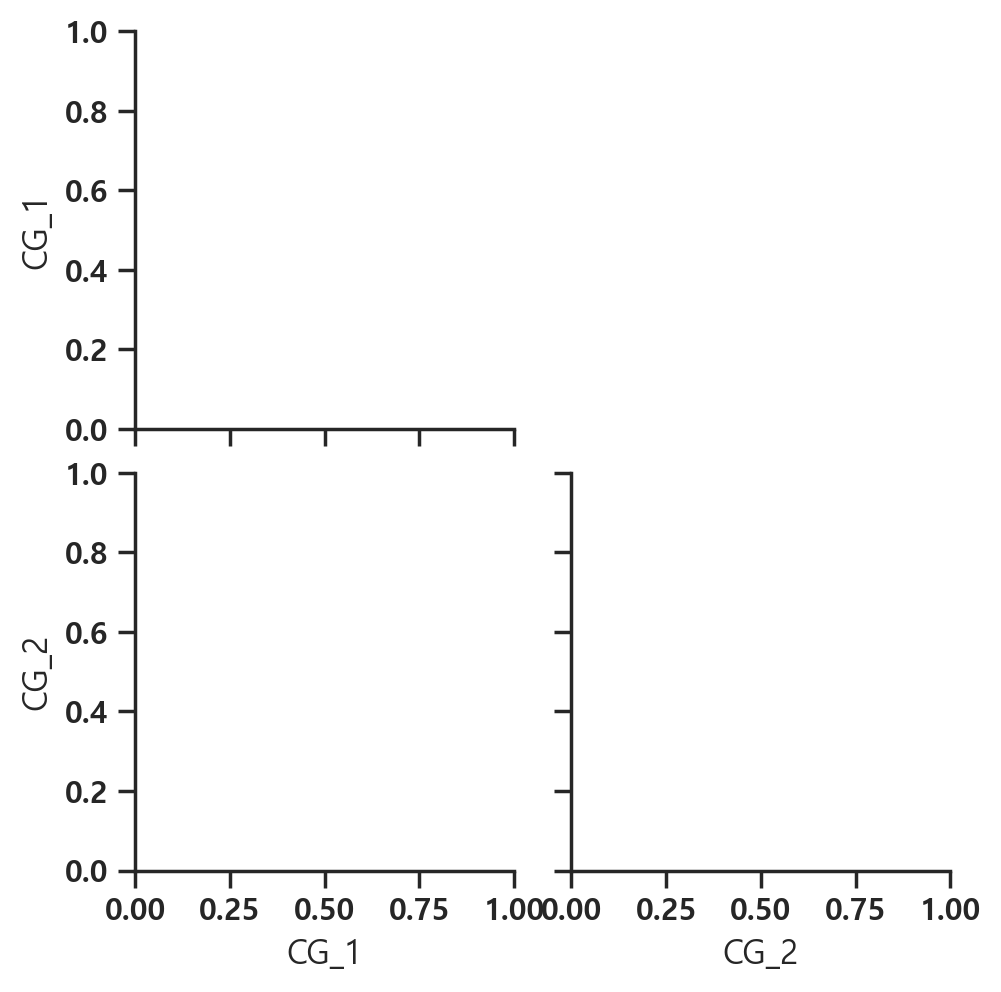

In [28]:
# Extract indices for normal & abnormals
df_ind = find_indices_labels(df1)

# Plot scatterplots
col_interest = ['Label', 'CG_1', 'CG_2']
show_scatter_plots_data(df1, col_interest, df_interest = df_ind)

In [ ]:
df_ = df[['CG_1', 'CG_2', 'CG_3', 'CG_4', 'TT_1', 'TT_2', 'TT_3', 'TT_4', 'TC_1_Avg', 'TC_2_Avg', 'Waterlevel']]

for col in df_.columns:
    plt.plot(df_[col][normal_ind], '.', color = 'b', markersize = 2)
    plt.plot(df_[col][abnormal_ind], '.', color = 'orange', markersize = 2)
    plt.axvline(np.argmax(np.where(df.Label == 0)), color = 'r', linewidth = 1, linestyle = ':')
    plt.title(col)
    plt.show()

In [ ]:
col_1, col_2 = 'CG_1', 'TT_1'
col_1, col_2 = 'CG_2', 'TT_2'
col_1, col_2 = 'CG_3', 'TT_3'
col_1, col_2 = 'CG_4', 'TT_4'

plt.figure(figsize = (3, 3))
plt.plot(df[col_1][normal_ind], df[col_2][normal_ind], 'b.', alpha = 0.1)
plt.xlabel(col_1)
plt.ylabel(col_2)
plt.show()

df.columns

In [ ]:
def plot_scatter_n_lineplots(cols, t, hue_types = ['normal', 'abnormal']):
    col_1, col_2 = cols
    
    normal_ind = df.Label == 0
    abnormal_ind = df.Label == 1

    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    plt.xticks(rotation=45)
    fig3, ax3 = plt.subplots()
    plt.xticks(rotation=45)

    for hue_type in hue_types:
        if hue_type == 'normal':
            ax1.plot(df[col_1][normal_ind], df[col_2][normal_ind], 'b.', alpha = 0.1)
            ax2.plot(t[normal_ind], df[col_1][normal_ind], 'b.', alpha = 0.3)
            ax3.plot(t[normal_ind], df[col_2][normal_ind], 'b.', alpha = 0.3)
        elif hue_type == 'abnormal':
            ax1.plot(df[col_1][abnormal_ind], df[col_2][abnormal_ind], 'r.', alpha = 0.1)
            ax2.plot(t[abnormal_ind], df[col_1][abnormal_ind], 'r.', alpha = 0.3)
            ax3.plot(t[abnormal_ind], df[col_2][abnormal_ind], 'r.', alpha = 0.3)

    ax1.set_xlabel(col_1)
    ax1.set_ylabel(col_2)
    fig1.show()

    ax2.set_xlabel(col_1)
    fig2.show()
    
    ax3.set_xlabel(col_2)
    fig3.show()

In [ ]:
cols = 'CG_3', 'TT_3'
# plot_scatter_n_lineplots(cols, t, hue_types = ['normal', 'abnormal'])
plot_scatter_n_lineplots(cols, t, hue_types = ['normal'])
# plot_scatter_n_lineplots(cols, t, hue_types = ['abnormal'])

#### **Pairplots**

In [ ]:
col_interest = ['Label', 'CG_1', 'CG_2', 'TT_1', 'TT_2']

X = df[col_interest].iloc[0:10001,:]

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('blue-yellow', ['blue', 'red'])

g = sns.pairplot(X, hue="Label", kind='reg', plot_kws={'scatter_kws': {'s':12, 'alpha': 0.3, 'edgecolor':"none"}}, corner=True, markers=["o","s"])
for ax in g.axes.flat:
    if ax is not None and not ax in g.diag_axes:
        for collection in ax.collections:
            collection.set_cmap(cmap)
            collection.set_array(X.index.to_numpy())
plt.show()

https://towardsdatascience.com/how-to-ensemble-clustering-algorithms-bf78d7602265

https://lovit.github.io/machine%20learning/2019/02/11/kmeans_ensemble/

In [ ]:
# col_interest = ['Label', 'CG_3', 'CG_4', 'TT_3', 'TT_4']
col_interest = ['Label',  'CG_4', 'TT_4']

X = df[col_interest].iloc[0:10001,:]

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('blue-yellow', ['blue', 'red'])

g = sns.pairplot(X, hue="Label", kind='reg', plot_kws={'scatter_kws': {'s':12, 'alpha': 0.3, 'edgecolor':"none"}}, corner=True, markers=["o","s"])
for ax in g.axes.flat:
    if ax is not None and not ax in g.diag_axes:
        for collection in ax.collections:
            collection.set_cmap(cmap)
            collection.set_array(X.index.to_numpy())
plt.show()